# Laboratory Exercise 3: Bayesian Networks


In [1]:
#@title **Exercise 1:Setting Up the Environment**
!pip install pgmpy
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.inference import BeliefPropagation
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:00


In [5]:
#@title **Exercise 2: Building a Simple Bayesian Network**

# Define the structure of the Bayesian Network
model = BayesianModel([('Weather', 'Traffic'), ('Traffic', 'Late')])

# Weather CPD
cpd_weather = TabularCPD(variable='Weather', variable_card=2, values=[[0.8], [0.2]])

# Traffic CPD given Weather
cpd_traffic = TabularCPD(variable='Traffic', variable_card=2,
                         values=[[0.9,0.5], [0.1,0.5]], # P(Light | Sunny, Rainy)
                         evidence=['Weather'],
                         evidence_card=[2])

# Late CPD given Traffic
cpd_late = TabularCPD(variable='Late', variable_card=2,
                         values=[[0.95,0.4], [0.05,0.6]], # P(On Time | Light, Heavy)
                         evidence=['Traffic'],
                         evidence_card=[2])

# Add CPDs to the model
model.add_cpds(cpd_weather, cpd_traffic, cpd_late)

# Check if the model is valid
assert model.check_model()

In [6]:
#@title **Exercise 3: Querying the Bayesian Network**

# Create an inference object
inference = VariableElimination(model)

# Query the probability of being Late given that Weather is Rainy
result = inference.query(variables=['Late'], evidence={'Weather': 1}) # 1 corresponds Rainy
print(result)

+---------+-------------+
| Late    |   phi(Late) |
+=========+=============+
| Late(0) |      0.6750 |
+---------+-------------+
| Late(1) |      0.3250 |
+---------+-------------+


In [7]:
#@title **Exercise 4: Parameter Learning**

# Create a synthetic dataset
# 0 for Sunny, 1 for Rainy
data = pd.DataFrame({
    'Weather': np.random.choice([0,1], size=1000, p=[0.8, 0.2]),
    'Traffic': np.nan,
    'Late': np.nan
})

# Fill traffic based on Weather
data.loc[data['Weather'] == 0, 'Traffic'] = np.random.choice(
    [0,1],
    size=data[data['Weather'] == 0].shape[0],
    p=[0.9,0.1])

data.loc[data['Weather'] == 1, 'Traffic'] = np.random.choice(
    [0,1],
    size=data[data['Weather'] == 1].shape[0],
    p=[0.5,0.5])

# Fill Late basesd on Traffic
data['Late'] = np.where(
    data['Traffic'] == 0,
    np.random.choice([0,1], size=data.shape[0], p=[0.95,0.05]),
    np.random.choice([0,1], size=data.shape[0], p=[0.4,0.6])
)

from pgmpy.estimators import MaximumLikelihoodEstimator

# Create a Bayesian Model
model = BayesianModel([('Weather', 'Traffic'), ('Traffic','Late')])

# Fit the model to the data using Maximum Likelihood Estimation
model.fit(data, estimator=MaximumLikelihoodEstimator)

# Check the estimated CPDs
for cpd in model.get_cpds():
  print(cpd)

+------------+-------+
| Weather(0) | 0.793 |
+------------+-------+
| Weather(1) | 0.207 |
+------------+-------+
+--------------+---------------------+---------------------+
| Weather      | Weather(0)          | Weather(1)          |
+--------------+---------------------+---------------------+
| Traffic(0.0) | 0.8915510718789408  | 0.48792270531400966 |
+--------------+---------------------+---------------------+
| Traffic(1.0) | 0.10844892812105927 | 0.5120772946859904  |
+--------------+---------------------+---------------------+
+---------+---------------------+--------------------+
| Traffic | Traffic(0.0)        | Traffic(1.0)       |
+---------+---------------------+--------------------+
| Late(0) | 0.9381188118811881  | 0.4479166666666667 |
+---------+---------------------+--------------------+
| Late(1) | 0.06188118811881188 | 0.5520833333333334 |
+---------+---------------------+--------------------+


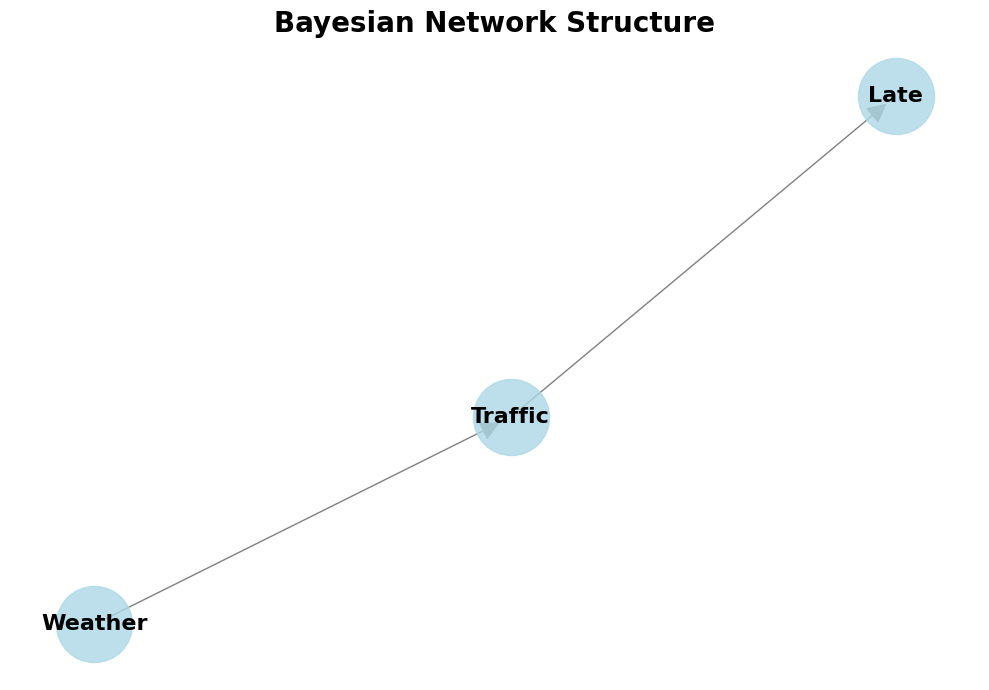

In [12]:
#@title **Exercise 5: Visualizing the Bayesian Network**

import matplotlib.pyplot as plt
import networkx as nx

def visualize_bn(model):
    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(model.edges())

    # Set up the plot
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=30)

    # Add a title
    plt.title("Bayesian Network Structure", fontsize=20, fontweight='bold')

    # Remove axis
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

visualize_bn(model)